In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns

from src.utils.simparam import SimParam  # class for show-up generator

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
years = [2023, 2024, 2025, 2026]
dct_data = {
    year: pd.read_excel(
        f"/home/antoine/projects/KAPpaxsim/data/raw/FY{year} KIX schedule forecast.xlsx",
        sheet_name="ALLdata",
        header=1,
    )
    for year in years
}
dct_data_processed = {}
dct_simparam = {}

# table should be formatted with following columns
# | A/D | T1/T2(MM/9C/7C/TW) | Intl Regions | Category(P/C/O) | Sector |
# | Flight Number | SEATS FC | PAX_SUM FC | Flight Date | Scheduled Time |

for key, data in dct_data.items():
    data["T1/T2(MM/9C/7C/TW)"] = data["Terminal"].replace(
        {"N": "T1", "S": "T1", 1: "T1", "L": "T2", np.nan: "-"}
    )

    data["Category(P/C/O)"] = data["Flight Type"].apply(lambda x: x[0])

    dct_name_change = {
        "Int / Dom": "Sector",
        "Int P Region": "Intl Regions",
        "Fight Number": "Flight Number",  # <- to be split with space between letters and digits
        "Seats": "SEATS FC",
        "PAX": "PAX_SUM FC",
        "Date": "Flight Date",
        "Time": "Scheduled Time",
    }

    dct_data_processed[key] = data.rename(columns=dct_name_change)


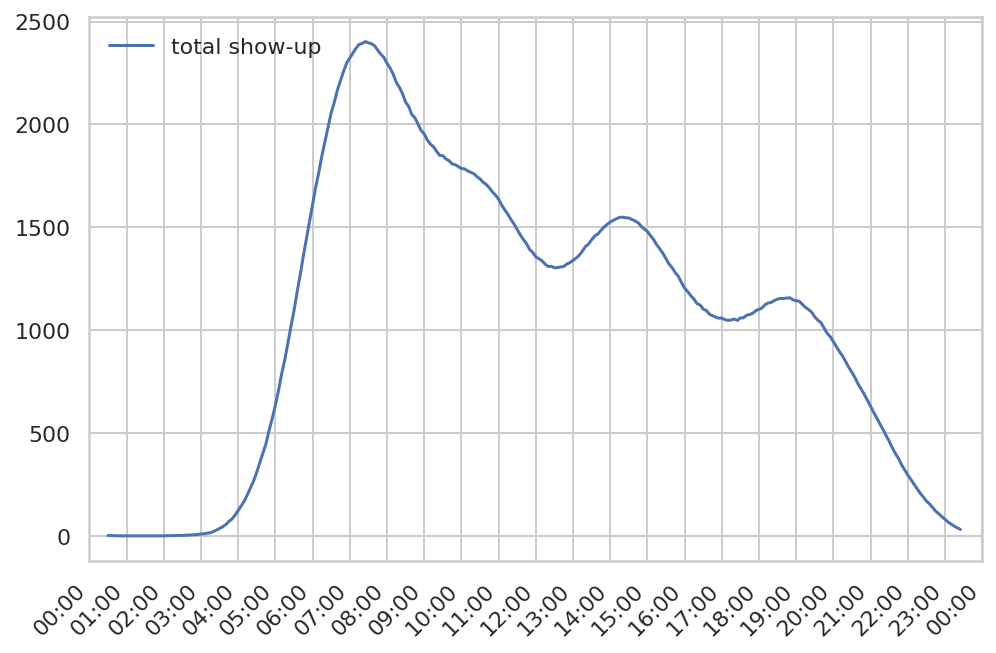

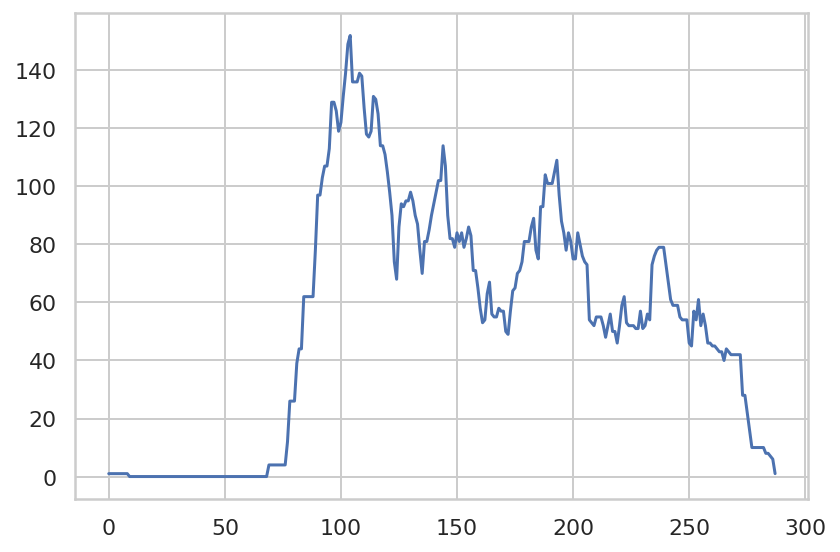

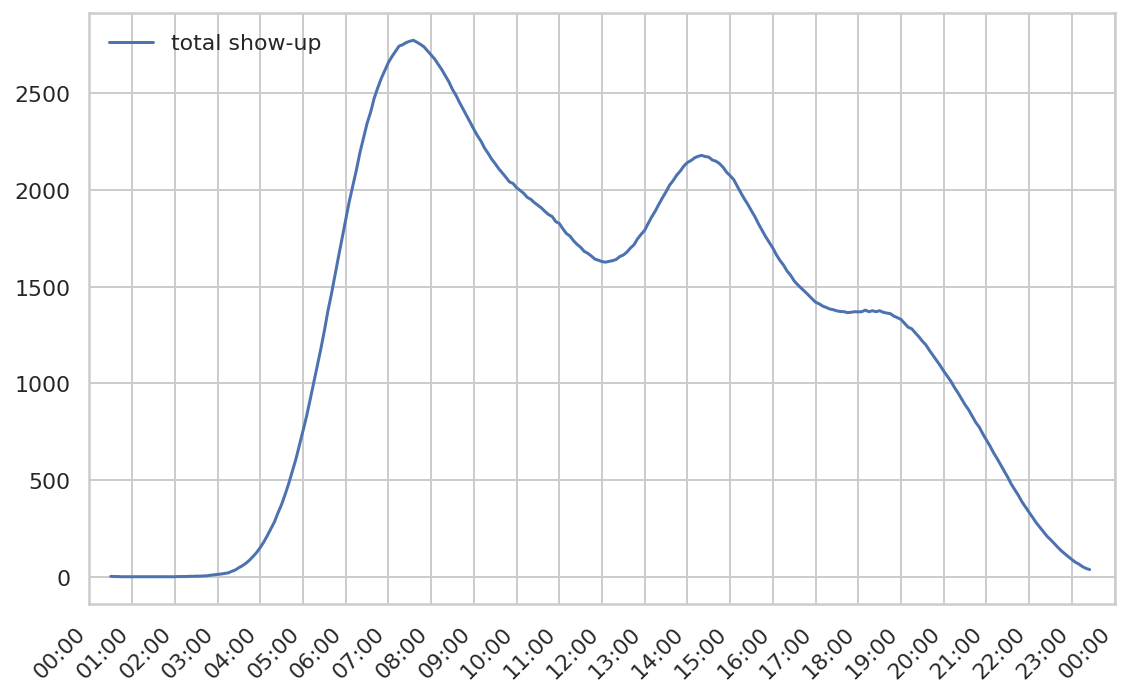

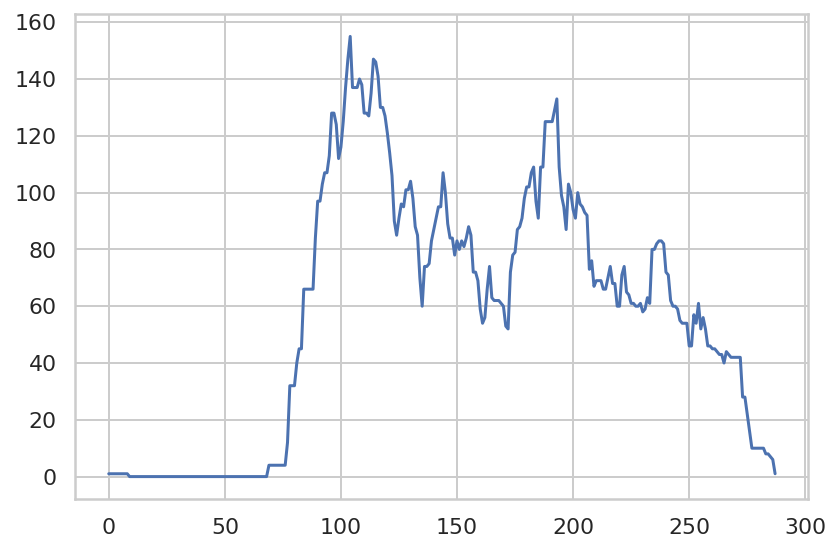

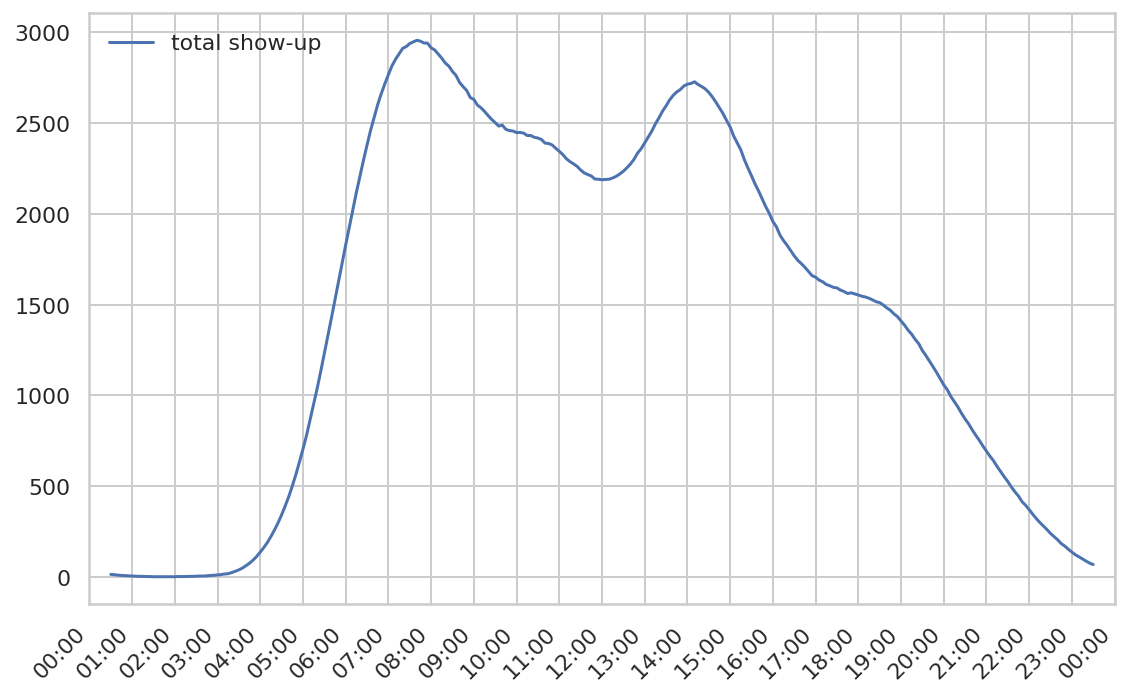

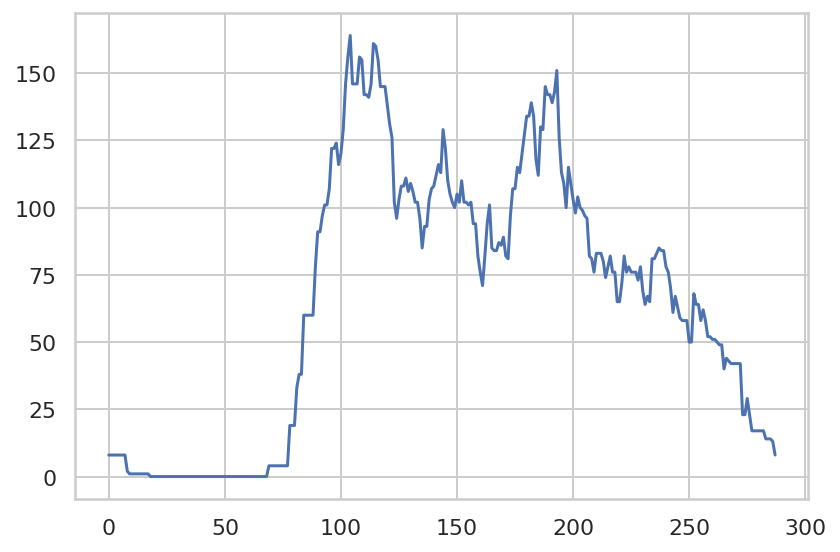

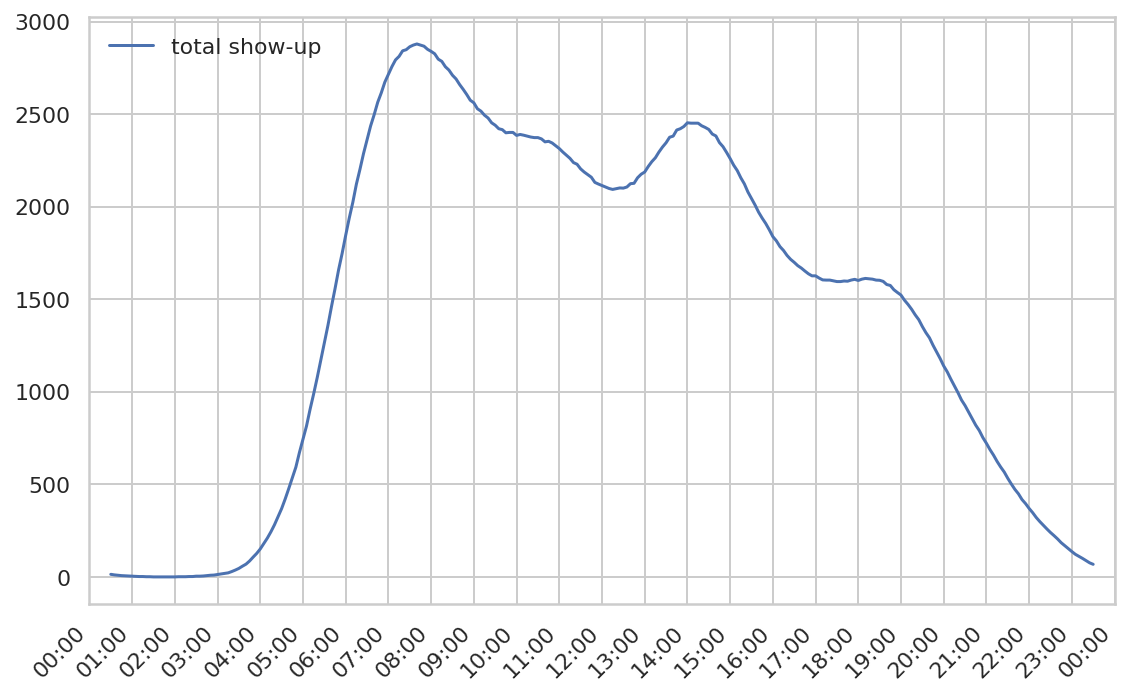

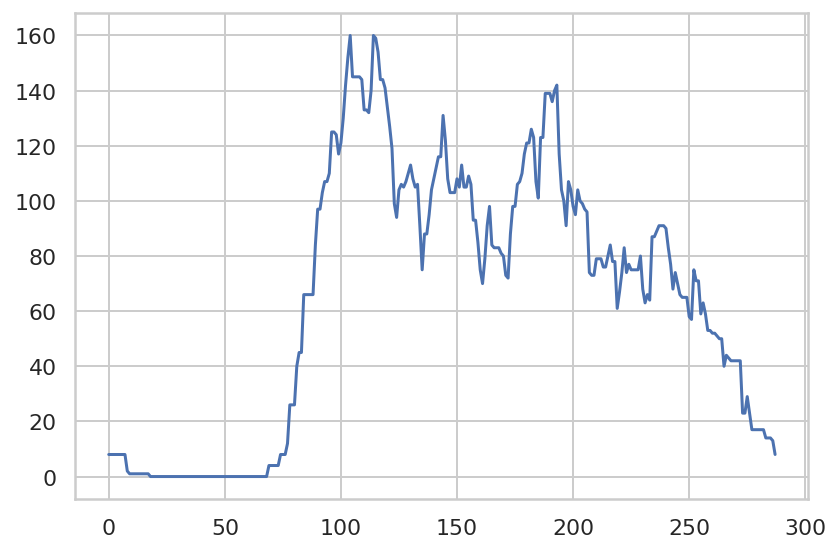

In [4]:
# really, we need to select busiest day of each year
# and let's plot on a single graph
for key, data_processed in dct_data_processed.items():
    dct_simparam[key] = SimParam()
    dct_simparam[key].schedule_from_df(data_processed)
    dct_simparam[key].schedule_cleanup()
    dct_simparam[key].schedule
    dct_simparam[key].schedule_filter(date_str=f"{key}-12-20")
    dct_simparam[key].show_up_from_file()
    dct_simparam[key].assign_flight_show_up_category_default()
    # dct_simparam.plot_show_up_categories_profiles()
    # dct_simparam.schedule['PAX_SUM FC'] = 10
    dct_simparam[key].assign_show_up()
    dct_simparam[key].plot_df_Pax()
    dct_simparam[key].assign_check_in()
    dct_simparam[key].df_Counters["total"].plot()


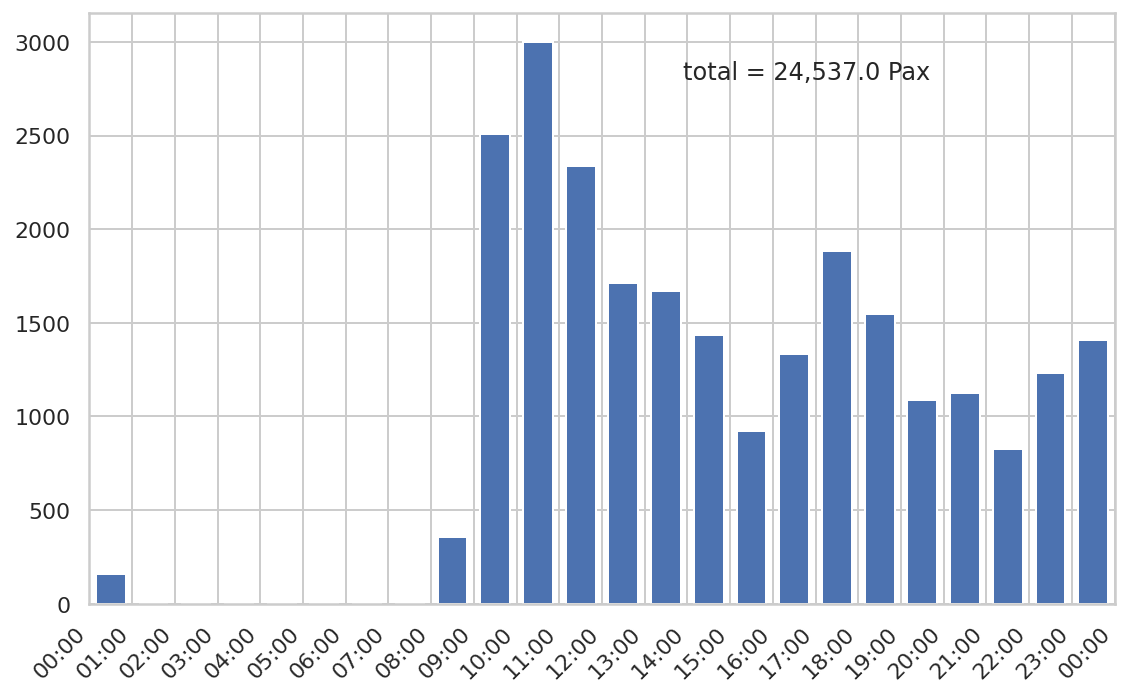

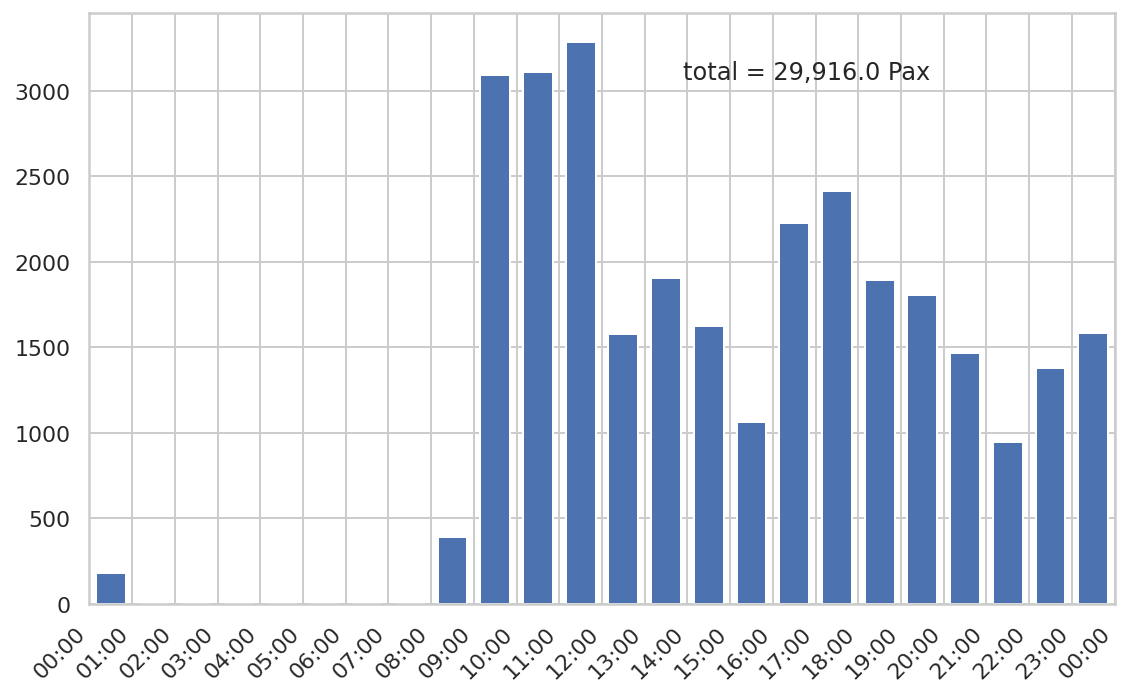

In [5]:
dct_plot_std = {}
for year in [2023, 2024]:
    dct_plot_std[year] = dct_simparam[year].plot_std()


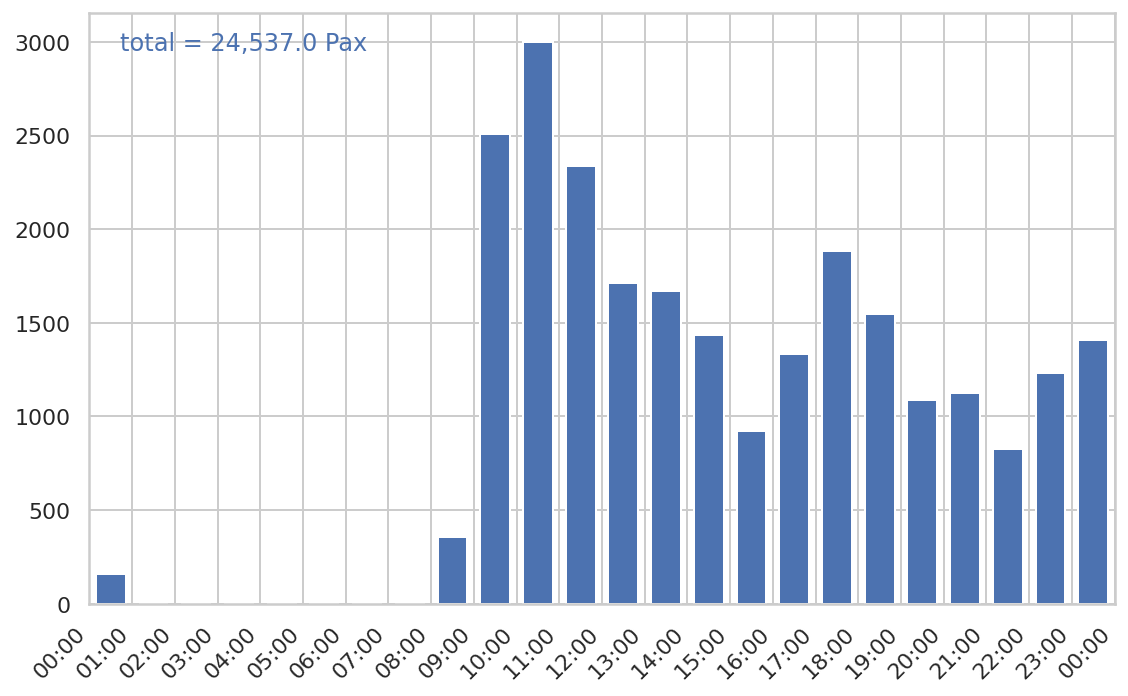

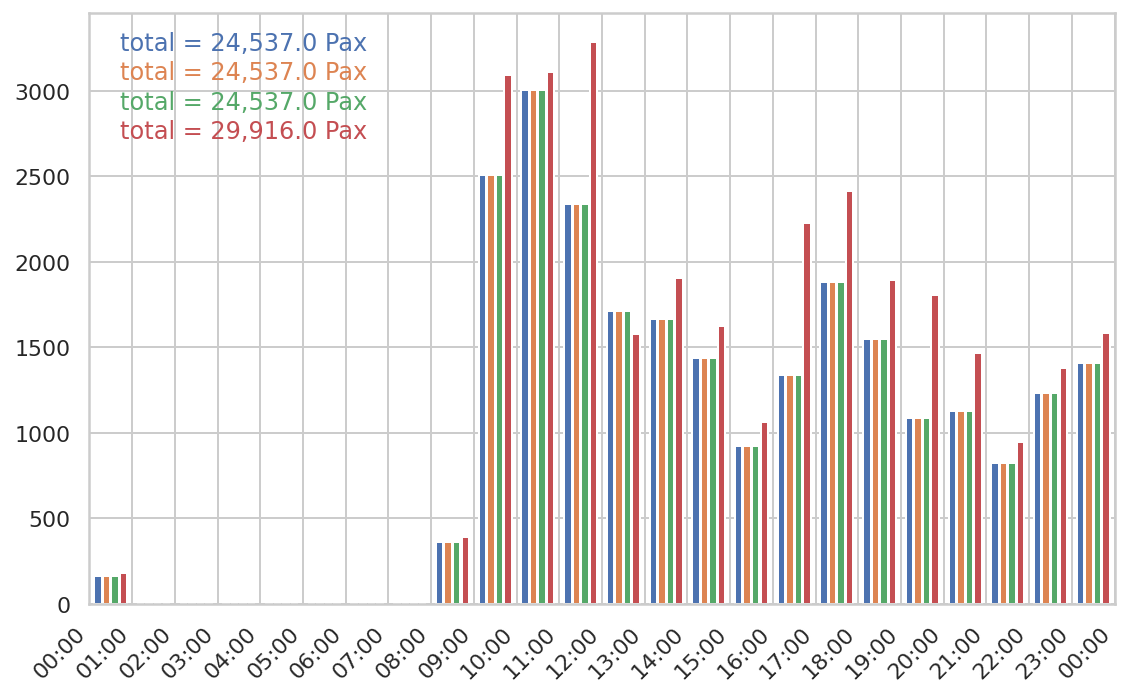

,sum
Scheduled Time,
2020-10-13 00:00:00,180.0
2020-10-13 01:00:00,0.0
2020-10-13 02:00:00,0.0
2020-10-13 03:00:00,0.0
2020-10-13 04:00:00,0.0
2020-10-13 05:00:00,0.0
2020-10-13 06:00:00,0.0
2020-10-13 07:00:00,0.0
2020-10-13 08:00:00,391.0


In [36]:
plot_compare = dct_simparam[2023].plot_std()
dct_simparam[2024].plot_std(compare_with=[plot_compare, plot_compare, plot_compare])
